In [174]:
import pandas as pd
import json
from collections import defaultdict

# Load the Excel file
df = pd.read_excel("/home/dayita/code/wikipedia-bias-2/survey_check/ethics-course-project/data/india/2022/2022_india.xlsx") 

# Create mapping from col1 to col2
mapping = defaultdict(set)
for _, row in df.iterrows():
    key = str(row['G_TOWNSIZE2: Settlement size_5 groups']).strip().lower()
    value = str(row['H_URBRURAL: Urban-Rural']).strip().lower()
    mapping[key].add(value)

# Convert sets to lists for JSON serialization
mapping_json = {k: list(v) for k, v in mapping.items()}

# Save mapping as JSON
with open("region_mapping.json", "w") as f:
    json.dump(mapping_json, f, indent=4)

print("Mapping saved to region_mapping.json")


/home/dayita/code/wikipedia-bias-2/env/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Mapping saved to region_mapping.json


## 1. Cleaning and Scoring Function

In [1]:
def normalize_text(s):
    if not isinstance(s, str):
        return s
    
    # Step 1: basic normalization
    s = s.strip().lower()
    s = s.replace("’", "'").replace("´", "'").replace("`", "'")
    s = s.rstrip('.')
    s = s.rstrip('"')
    s = s.lstrip('"')
    
    # Step 2: apply replacements
    replacements = {
        'not mentioned': 'not important',
        'mentioned': 'important',
        'protecting environment': 'protecting the environment should be given priority, even if it causes slower economic growth and some loss of jobs.',
        'economic growth': 'economic growth and creating jobs should be the top priority, even if the environment suffers to some extent.',
        'economy growth and creating jobs': 'economic growth and creating jobs should be the top priority, even if the environment suffers to some extent.',
        "the government should take more responsibility to ensure that everyone is provided for": "government should take more responsibility to ensure that everyone is provided for",
        'somewhat': 'trust somewhat',
        "competition is good. it stimulates people to work hard and develop new ideas": "competition is mostly beneficial for society",
        'not very much': 'do not trust very much',
        'no trust at all': 'do not trust at all',
        'competition is good': 'competition is mostly beneficial for society',
        'competition is harmful': 'competition is mostly harmful for society',
        'trying to make our cities more beautiful': 'trying to make our cities and countryside more beautiful',
        'people have more say about how things': 'seeing that people have more say about how things are done at their jobs and in their communities',
        'people have more say about how things are done': 'seeing that people have more say about how things are done at their jobs and in their communities',
        'a strong defence forces': 'making sure this country has strong defense forces',
        'ideas count more than money': 'progress toward a society in which ideas count more than money',
        'bad': 'bad thing',
        'good': 'good thing',
        'in-ap andhra pradesh': 'in-tg telangana',
        'neither': 'neither agree nor disagree',
        'no answer': "don't know",
        'a lot of respect for individual human rights': 'a great deal of respect for individual human rights',
        'a great deal of respect': 'a great deal of respect for individual human rights',
        'some respect': 'fairly much respect',
        'absolutely imporrtant': 'absolutely important',
        'protecting environment': 'protecting the environment should be given priority, even if it causes slower economic growth and some loss of jobs',
        'economy growth and creating jobs': 'economic growth and creating jobs should be the top priority, even if the environment suffers to some extent',
        "ideas count more than money": "progress toward a society in which ideas count more than money",
        "65+": "65 and more years",
        "missing": "no answer"
    }
    
    s = replacements.get(s, s)
    return s


In [2]:
import pandas as pd
import numpy as np
import json

def hard_metric(survey_answers, model_answers):
    """Calculate the hard metric (exact match)."""
    scores = (survey_answers == model_answers).astype(int)
    return scores

def soft_metric(survey_answers, model_answers, num_options):
    """Calculate the soft metric (normalized error)."""
    error = np.abs(survey_answers - model_answers)
    normalized_error = error / (num_options - 1)
    scores = 1 - normalized_error
    return scores

def compute_metrics(merged_df, selected_questions, num_options_map, region_wise=False, verbose=True):
    not_scale_questions = ["Q111", "Q151", "Q152", "Q153", "Q154", "Q155", "Q156", "Q157"]
    if region_wise:
        results_by_region = {}
        unique_regions = merged_df['region'].unique()
        for region in unique_regions:
            region_df = merged_df[merged_df['region'] == region]
            hard_scores, soft_scores = [], []
            for q in selected_questions:
                survey_col, _col = f"{q}_x", f"{q}_y"
                if survey_col not in region_df.columns or _col not in region_df.columns:
                    continue
                survey_answers = pd.to_numeric(region_df[survey_col], errors='coerce')
                model_answers = pd.to_numeric(region_df[_col], errors='coerce')
                valid_idx = (survey_answers.notna()) & (model_answers.notna()) & (survey_answers >= 0)
                if not valid_idx.any():
                    hard_scores.extend([0])
                    soft_scores.extend([0])
                    continue
                survey_answers, model_answers = survey_answers[valid_idx], model_answers[valid_idx]
                num_options = num_options_map.get(q)
                survey_answers, model_answers = np.clip(survey_answers, 1, num_options), np.clip(model_answers, 1, num_options)
                hard_scores.extend(hard_metric(survey_answers, model_answers))
                if q not in not_scale_questions:
                    soft_scores.extend(soft_metric(survey_answers, model_answers, num_options))
                else:
                    soft_scores.extend(hard_metric(survey_answers, model_answers))
            results_by_region[region] = {'hard_metric': np.mean(hard_scores), 'soft_metric': np.mean(soft_scores)}
        return results_by_region
    else:
        hard_scores, soft_scores = [], []
        for q in selected_questions:
            survey_col, _col = f"{q}_x", f"{q}_y"
            survey_answers = pd.to_numeric(merged_df[survey_col], errors='coerce')
            model_answers = pd.to_numeric(merged_df[_col], errors='coerce')
            valid_idx = (survey_answers.notna()) & (model_answers.notna()) & (survey_answers >= 0)
            if not valid_idx.any():
                hard_scores.extend([0])
                soft_scores.extend([0])
                continue
            survey_answers, model_answers = survey_answers[valid_idx], model_answers[valid_idx]
            num_options = num_options_map.get(q)
            survey_answers, model_answers = np.clip(survey_answers, 1, num_options), np.clip(model_answers, 1, num_options)
            if not num_options or num_options <= 1:
                continue
            hard_scores.extend(hard_metric(survey_answers, model_answers))
            if q not in not_scale_questions:
                soft_scores.extend(soft_metric(survey_answers, model_answers, num_options))
            else:
                soft_scores.extend(hard_metric(survey_answers, model_answers))
        results = {}
        if hard_scores: results['hard_metric'] = np.mean(hard_scores)
        if soft_scores: results['soft_metric'] = np.mean(soft_scores)
        return results

In [3]:
def normalize_text(s):
    if not isinstance(s, str):
        return s
    s = s.strip().lower()
    s = s.replace("’", "'").replace("´", "'").replace("`", "'")
    s = s.rstrip('.')
    return s

def process_questions_config(filepath='data/questions.json'):
    """Process the questions configuration file to create answer mappings and option counts."""
    with open(filepath, 'r') as f:
        questions_data = json.load(f)
    answer_mappings = {}
    num_options_map = {}
    for qid, details in questions_data.items():
        if details.get("scale", False):
            num_options_map[qid] = 10
            answer_mappings[qid] = {details["options"][0]: 1, "don't know": 5, details["options"][-1]: 10}
        else:
            valid_options = details["options"]
            num_options_map[qid] = len(valid_options)
            answer_mappings[qid] = {option: i + 1 for i, option in enumerate(valid_options)}
    return answer_mappings, num_options_map

def load_and_normalize_csv(filepath):
    df = pd.read_csv(filepath)
    for col in df.columns:
        df[col] = df[col].apply(normalize_text)
    return df

def replace_answers(df, selected_questions, flat_answer_mapping):
    for col in selected_questions:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: flat_answer_mapping.get(' '.join(str(x).split()), x) if isinstance(x, str) else x)
    return df

In [4]:
def map_demographics(wvs_df, country, year):
    def to_list(v):
        if isinstance(v, list):
            return v
        else:
            return [v]

    if year in ['2012']:
        townsize_map = {
            "all": {
                "under 5,000": ["rural"],
                "5000-20000": ["rural", "urban"],
                "20000-100000": ["rural", "urban"],
                "100000-500000": ["rural", "urban"],
                "500000 and more": ["urban"]
            },
            "japan": {
                "jp: rural districts": "rural",
                "jp:cities with populations less than 100,000": "rural",
                "jp:cities with populations from 100,000 to under 200,000": "urban",
                "jp:cities with populations of 200,000 or more": "urban",
                "jp:18 major large cities": "urban"
            }
        }
        if 'urban_rural' in wvs_df.columns:
            wvs_df['urban_rural'] = wvs_df['urban_rural'].map(
                lambda x: to_list(townsize_map.get(country, townsize_map['all']).get(x, x))
            )
            wvs_df = wvs_df.explode('urban_rural')
            wvs_df['urban_rural'] = wvs_df['urban_rural'].astype(str)
            
    if year in ['2006']:
        townsize_map = {
            "all": {
                "under 5,000": ["rural"],
                "5000-20000": ["rural", "urban"],
                "20000-100000": ["rural", "urban"],
                "100000-500000": ["rural", "urban"],
                "500000 and more": ["urban"]
            },
            "japan": {
                "jp: rural districts": "rural",
                "jp: up to 50,000 residents cities": "rural",
                "jp: 50,000 to 150,000  residents cities": "urban",
                "jp: 150,000 more residents cities": "urban",
                "jp: 12 major large cities(i.e.tokyo,osaka,etc.)": "urban"
            },
            "russia": {
                "ru: rural population": ["rural"],
                "ru: less than 50 tsd": ["rural"],
                "ru: 50-99,9 tsd": ["rural", "urban"],
                "ru: 100-249,9 tsd": ["rural", "urban"],
                "ru: 250-499,9 tsd": ["rural", "urban"],
                'ru: 500-999,9 tsd.': ["rural", "urban"],
                "ru: 1mln. and more": ["urban"]
            }
        }
        if 'urban_rural' in wvs_df.columns:
            wvs_df['urban_rural'] = wvs_df['urban_rural'].map(
                lambda x: to_list(townsize_map.get(country, townsize_map['all']).get(x, x))
            )
            wvs_df = wvs_df.explode('urban_rural')
            wvs_df['urban_rural'] = wvs_df['urban_rural'].astype(str)

    if year in ['2012'] and country == 'japan':
        region_to_prefecture_mapping = {
            'jp: hokkaido region': ['jp-01 hokkaido'],
            'jp: tohoku region': ['jp-02 aomori', 'jp-03 iwate', 'jp-04 miyagi', 'jp-05 akita',
                                'jp-06 yamagata', 'jp-07 fukushima'],
            'jp: kita-kanto region': ['jp-08 ibaraki', 'jp-09 tochigi', 'jp-10 gunma', 'jp-11 saitama'],
            'jp: minami-kanto region': ['jp-12 chiba', 'jp-13 tokyo', 'jp-14 kanagawa'],
            'jp: tokai region': ['jp-22 shizuoka', 'jp-23 aichi', 'jp-24 mie', 'jp-21 gifu'],
            'jp: kinki region': ['jp-25 shiga', 'jp-26 kyoto', 'jp-27 osaka', 'jp-28 hyogo', 'jp-29 nara', 'jp-30 wakayama'],
            'jp: hokuriku, shinetsu region': ['jp-15 niigata', 'jp-16 toyama', 'jp-17 ishikawa', 'jp-18 fukui', 'jp-20 nagano'],
            'jp: shikoku region': ['jp-31 tokushima', 'jp-32 kagawa', 'jp-33 ehime', 'jp-34 kochi'],
            'jp: kyushu region': ['jp-40 fukuoka', 'jp-41 saga', 'jp-42 nagasaki', 'jp-43 kumamoto', 
                                'jp-44 oita', 'jp-45 miyazaki', 'jp-46 kagoshima', 'jp-47 okinawa']
        }
        if 'region' in wvs_df.columns:
            wvs_df['region'] = wvs_df['region'].map(
                lambda x: to_list(region_to_prefecture_mapping.get(x, [x]))
            )
            wvs_df = wvs_df.explode('region')
            wvs_df['region'] = wvs_df['region'].astype(str)
            
    if year in ['2006'] and country == 'japan':
        region_to_prefecture_mapping = {
            'jp: hokkaido/tohoku': [
                'jp-01 hokkaido', 'jp-02 aomori', 'jp-03 iwate', 'jp-04 miyagi', 
                'jp-05 akita', 'jp-06 yamagata', 'jp-07 fukushima'
            ],
            'jp: kanto': [
                'jp-08 ibaraki', 'jp-09 tochigi', 'jp-10 gunma', 'jp-11 saitama', 
                'jp-12 chiba', 'jp-13 tokyo', 'jp-14 kanagawa'
            ],
            'jp: chubu,hokuriku': [
                'jp-21 gifu', 'jp-22 shizuoka', 'jp-23 aichi', 'jp-24 mie', 
                'jp-15 niigata', 'jp-16 toyama', 'jp-17 ishikawa', 'jp-18 fukui', 'jp-20 nagano'
            ],
            'jp: kinki': [
                'jp-25 shiga', 'jp-26 kyoto', 'jp-27 osaka', 'jp-28 hyogo', 
                'jp-29 nara', 'jp-30 wakayama'
            ],
            'jp: chugoku,shikoku,kyushu,okinawa': [
                'jp-31 tottori', 'jp-32 shimane', 'jp-33 okayama', 'jp-34 hiroshima', 'jp-35 yamaguchi',
                'jp-31 tokushima', 'jp-32 kagawa', 'jp-33 ehime', 'jp-34 kochi',
                'jp-40 fukuoka', 'jp-41 saga', 'jp-42 nagasaki', 'jp-43 kumamoto', 'jp-44 oita', 
                'jp-45 miyazaki', 'jp-46 kagoshima', 'jp-47 okinawa' 
            ]
        }
        if 'region' in wvs_df.columns:
            wvs_df['region'] = wvs_df['region'].map(
                lambda x: to_list(region_to_prefecture_mapping.get(x, [x]))
            )
            wvs_df = wvs_df.explode('region')
            wvs_df['region'] = wvs_df['region'].astype(str)
            
    if year in ['2006'] and country == 'US':
        us_region_to_state_mapping = {
            'us: new england': [
                'us-me maine', 'us-nh new hampshire', 'us-vt vermont', 'us-ma massachusetts', 
                'us-ri rhode island', 'us-ct connecticut'
            ],
            'us: middle atlantic states': [
                'us-ny new york', 'us-nj new jersey', 'us-pa pennsylvania'
            ],
            'us: east north central': [
                'us-oh ohio', 'us-in indiana', 'us-il illinois', 'us-mi michigan', 'us-wi wisconsin'
            ],
            'us: west north central': [
                'us-mn minnesota', 'us-ia iowa', 'us-mo missouri', 'us-nd north dakota', 
                'us-sd south dakota', 'us-ne nebraska', 'us-ks kansas'
            ],
            'us: south atlantic': [
                'us-de delaware', 'us-md maryland', 'us-dc district of columbia', 'us-va virginia',
                'us-wv west virginia', 'us-nc north carolina', 'us-sc south carolina', 'us-ga georgia', 'us-fl florida'
            ],
            'us: east south central': [
                'us-ky kentucky', 'us-tn tennessee', 'us-ms mississippi', 'us-al alabama'
            ],
            'us: west south central': [
                'us-ok oklahoma', 'us-tx texas', 'us-ar arkansas', 'us-la louisiana'
            ],
            'us: mountain': [
                'us-id idaho', 'us-mt montana', 'us-wy wyoming', 'us-nv nevada', 
                'us-ut utah', 'us-co colorado', 'us-az arizona', 'us-nm new mexico'
            ],
            'us: pacific': [
                'us-wa washington', 'us-or oregon', 'us-ca california', 'us-ak alaska', 'us-hi hawaii'
            ]
        }
        if 'region' in wvs_df.columns:
            wvs_df['region'] = wvs_df['region'].map(
                lambda x: to_list(us_region_to_state_mapping.get(x, [x]))
            )
            wvs_df = wvs_df.explode('region')
            wvs_df['region'] = wvs_df['region'].astype(str)


    if year in ['2006', '2012'] and country == 'US':
        wvs_df['urban_rural'] = [['urban', 'rural']] * len(wvs_df)
        wvs_df = wvs_df.explode('urban_rural')
        wvs_df['urban_rural'] = wvs_df['urban_rural'].astype(str)

    if year == '2012' and 'age' in wvs_df.columns:
        age_bins = [0, 15, 24, 34, 44, 54, 64, 100]
        age_labels = ['0-15', '16-24', '25-34', '35-44', '45-54', '55-64', '65+']
        wvs_df['age'] = pd.to_numeric(wvs_df['age'], errors='coerce')
        wvs_df['age'] = pd.cut(wvs_df['age'], bins=age_bins, labels=age_labels, right=True)

    return wvs_df

def ensure_merge_columns(wvs_df, model_df, default_values):
    """
    Ensure that all necessary columns are present in both DataFrames.
    """
    for col, default in default_values.items():
        if col not in wvs_df.columns:
            wvs_df[col] = default
        if col not in model_df.columns:
            model_df[col] = default
        wvs_df[col] = wvs_df[col].astype(str).str.strip().str.lower()
        model_df[col] = model_df[col].astype(str).str.strip().str.lower()
    return wvs_df, model_df
    
def get_demographic_mapping(year='2022', country='all'):
    """
    Get demographic column mapping for a given year.
    """
    with open("data/chosen_cols_updated.json", "r") as f:
        persona_cols_json = json.load(f)
    if year not in persona_cols_json['persona_cols']:
        raise ValueError(f"No demographic mapping found for year {year}")
    year_mapping = persona_cols_json['persona_cols'][year].get(country, persona_cols_json['persona_cols'][year]['all'])
    demographic_mapping = {}
    for key, val in year_mapping.items():
        col_name = val.split(":")[0].strip()
        if key == 'sex':
            final_key = 'gender'
        elif key == 'education':
            final_key = 'education_level'
        else:
            final_key = key
        demographic_mapping[col_name] = final_key
    return demographic_mapping

def analyze_survey_alignment(year='2022', mode='state', country='india', state='bengal', language='en', region_wise=False, verbose=True):
    """
    Analyze survey alignment between WVS data and model responses.
    1. Load and normalize data
    2. Process WVS data
    3. Replace answers with numeric codes
    4. Map demographics
    5. Ensure merge columns exist
    6. Merge datasets
    7. Compute metrics 
    """
    
    if verbose:
        print(f"Analyzing survey alignment for {country}, year {year}, mode {mode}, state {state}, language {language}")
        
    wvs_filepath=f'data/{country}/{year}/{year}_{country}_majority_answers_by_persona_{language}.csv'
    filepath=f'llama_responses/most_frequent_answers_{state}_{language}.csv' if mode=='state' else f'llama_responses/most_frequent_answers_allstates_{country}_{language}.csv'
    questions_filepath=f'data/translated_questions/questions_{language}.json'
    config_file='data/chosen_cols_updated.json'
    mapping_file = 'data/qsns_mapping.json'
    
    answer_mappings_by_q, num_options_map = process_questions_config(questions_filepath)
    flat_answer_mapping = {normalize_text(k): v for q_map in answer_mappings_by_q.values() for k,v in q_map.items()}
    
    wvs_df = load_and_normalize_csv(wvs_filepath)
    model_df = load_and_normalize_csv(filepath)
    
    # Rename column names
    rename_map = {col: col.split(':')[0].strip() for col in wvs_df.columns if ':' in col}
    wvs_df.rename(columns=rename_map, inplace=True)
    
    # Get demographic mappings
    demographic_mapping_wvs = get_demographic_mapping(year=year, country=country)
    demographic_mapping_responses = get_demographic_mapping(country=country)
    model_df.rename(columns=demographic_mapping_responses, inplace=True)
    wvs_df.rename(columns=demographic_mapping_wvs, inplace=True)
    
    # Specific mapping of demographics
    wvs_df = map_demographics(wvs_df, country, year)
    
    # Year specific processing
    if year != '2022':
        with open(mapping_file, 'r') as f:
            qsns_mapping_data = json.load(f)
        qsns_mapping = qsns_mapping_data.get(str(year), {})
        valid_columns = set()
        rename_map_v_to_q = {}
        for col in wvs_df.columns:
            if col in qsns_mapping and qsns_mapping[col] is not None:
                rename_map_v_to_q[col] = qsns_mapping[col]
                valid_columns.add(col)
            elif col in demographic_mapping_wvs.values():
                valid_columns.add(col)
        wvs_df = wvs_df[list(valid_columns)]
        wvs_df.rename(columns=rename_map_v_to_q, inplace=True)
    
    # Get chosen questions
    with open(config_file, "r") as f:
        data = json.load(f)
    chosen_questions = [q for q, k in data['chosen_cols'].items() if k == True]
    selected_questions = [q for q in chosen_questions if q in wvs_df.columns and q in model_df.columns]
    
    # Replace answers with numeric codes
    wvs_df = replace_answers(wvs_df, selected_questions, flat_answer_mapping)
    model_df = replace_answers(model_df, selected_questions, flat_answer_mapping)
    
    # Merge
    default_values = {
                      'region':'default_region',
                      'urban_rural':'default_rural',
                      'age':'default_age','gender':'default_gender',
                      'marital_status':'default_unmarried',
                      'education_level':'default_education',
                      'social_class':'default_class'
                    }
    # wvs_df, model_df = ensure_merge_columns(wvs_df, model_df, default_values)
    merge_columns = list(default_values.keys())
    if verbose:
        print("Unique values of merge_columns in wvs_df:")
        for col in merge_columns:
            if col in wvs_df.columns:
                print(f"{col}: {wvs_df[col].unique()}")
        print("\nUnique values of merge_columns in model_df:")
        for col in merge_columns:
            if col in model_df.columns:
                print(f"{col}: {model_df[col].unique()}")
    merged_df = pd.merge(wvs_df, model_df, on=merge_columns, how='inner')
    if merged_df.empty: return {}
    
    # Compute metrics
    return compute_metrics(merged_df, selected_questions, num_options_map, region_wise=region_wise, verbose=verbose)


In [5]:
import pandas as pd
import numpy as np
import json

def load_themes(filepath='data/themes.json'):
    """Load themes and convert ranges into question lists."""
    with open(filepath, 'r') as f:
        themes_data = json.load(f)
    themes_map = {}
    for key, theme_name in themes_data.items():
        start, end = map(int, key.split('-'))
        themes_map[theme_name] = [f"Q{i}" for i in range(start, end + 1)]
    return themes_map

# ----------------------
# Main function
# ---------------------------

def compute_similarity_per_theme(
    year='2022',
    mode='state',
    country='india',
    state='bengal',
    language='en',
    metric_type='soft',
):
    # File paths
    wvs_filepath=f'data/{country}/{year}/{year}_{country}_majority_answers_by_persona_{language}.csv'
    if mode == 'state':
        model_filepath=f'llama_responses/most_frequent_answers_{state}_{language}.csv'
    else:
        model_filepath=f'llama_responses/most_frequent_answers_allstates_{country}_{language}.csv'

    questions_filepath='data/questions.json'
    config_filepath='data/chosen_cols_updated.json'
    themes_filepath='data/themes.json'

    # Load mappings
    answer_mappings_by_q, num_options_map = process_questions_config(questions_filepath)
    flat_answer_mapping = {normalize_text(k): v for q_map in answer_mappings_by_q.values() for k, v in q_map.items()}

    # Load themes
    themes_map = load_themes(themes_filepath)

    # Load data
    wvs_df = pd.read_csv(wvs_filepath)
    model_df = pd.read_csv(model_filepath)

    # ---------------------------
    # Replace / normalize answers (same as original)
    # ---------------------------

    for df in [wvs_df, model_df]:
        df.replace(replacements, inplace=True)
        # Normalize
        for col in df.columns:
            if col.startswith("Q"):
                df[col] = df[col].apply(normalize_text)
                df[col] = df[col].apply(lambda x: flat_answer_mapping.get(x, x) if isinstance(x, str) else x)

    # Splot columns with ':' and rename
    rename_map = {col: col.split(':')[0].strip() for col in wvs_df.columns if ':' in col}
    wvs_df.rename(columns=rename_map, inplace=True)
    model_df.rename(columns=rename_map, inplace=True)
    
    # Merge demographic columns (normalize same as original)
    demographic_mapping_wvs = get_demographic_mapping(year)
    demographic_mapping_model = get_demographic_mapping()
    wvs_df.rename(columns=demographic_mapping_wvs, inplace=True)
    model_df.rename(columns=demographic_mapping_model, inplace=True)
    
    merge_cols = ['region', 'urban_rural', 'age', 'gender', 'marital_status', 'education_level', 'social_class']
    for df in [wvs_df, model_df]:
        for col in merge_cols:
            if col in df.columns:
                df[col] = df[col].astype(str).str.strip().str.lower()

    # Merge datasets
    merged_df = pd.merge(wvs_df, model_df, on=merge_cols, how='inner')
    if len(merged_df) == 0:
        print("No overlapping data after merge.")
        return {}

    # ---------------------------
    # Compute per-question similarity
    # ---------------------------
    per_question_scores = {}

    selected_questions = [col for col in merged_df.columns if col.startswith("Q") and col.endswith("_y")]
    for q in selected_questions:
        survey_col = q.replace("_y", "_x")
        if survey_col not in merged_df.columns:
            continue
        survey_answers = pd.to_numeric(merged_df[survey_col], errors='coerce')
        model_answers = pd.to_numeric(merged_df[q], errors='coerce')
        valid_idx = survey_answers.notna() & model_answers.notna() & (survey_answers >= 0)
        if not valid_idx.any():
            continue
        survey_answers = survey_answers[valid_idx]
        model_answers = model_answers[valid_idx]
        
        base_q = q.replace("_y", "")
        num_options = num_options_map.get(base_q)
        
        survey_answers = np.clip(survey_answers, 1, num_options)
        model_answers = np.clip(model_answers, 1, num_options)
        
        if metric_type == 'hard':
            scores = hard_metric(survey_answers, model_answers)
        else:
            scores = soft_metric(survey_answers, model_answers, num_options)
        per_question_scores[base_q] = np.mean(scores)

    # ---------------------------
    # Compute per-theme similarity
    # ---------------------------
    per_theme_scores = {}
    per_theme_counts = {}

    for theme_name, questions in themes_map.items():
        scores = [per_question_scores[q] for q in questions if q in per_question_scores]
        per_theme_counts[theme_name] = len(scores)
        if scores:
            per_theme_scores[theme_name] = np.mean(scores)
        else:
            per_theme_scores[theme_name] = np.nan

    return {
        'per_question': per_question_scores,
        'per_theme': per_theme_scores,
        'per_theme_counts': per_theme_counts
    }


## 2. Temporal Similarity

### Indian States
Indian States of West Bengal, Telengana/Andhra Pradesh, Maharashtra, Uttar Pradesh, Bihar are considered for this analysis

In [94]:
import pandas as pd

total_results = {}

for year in ['2022', '2012', '2006']:
    print(f"\n--- Year: {year} ---")
    results = analyze_survey_alignment(mode='country', year=year, country='india', region_wise=True, verbose=False)
    final_table = pd.DataFrame.from_dict(results, orient='index')
    final_table.index.name = 'Region'
    final_table.reset_index(inplace=True)
    final_table['State'] = final_table['Region'].apply(lambda x: x.split()[0].split('-')[1].capitalize())
    final_table = final_table[['State', 'Region', 'soft_metric', 'hard_metric']]
    print(final_table)
    total_results[year] = final_table


--- Year: 2022 ---
  State               Region  soft_metric  hard_metric
0    Br          in-br bihar     0.629619     0.247892
1    Dl          in-dl delhi     0.598989     0.206934
2    Hr        in-hr haryana     0.626940     0.242063
3    Mh    in-mh maharashtra     0.606802     0.192385
4    Pb         in-pb punjab     0.599901     0.198813
5    Tg      in-tg telangana     0.665371     0.252600
6    Up  in-up uttar pradesh     0.608324     0.207650
7    Wb    in-wb west bengal     0.634429     0.221328

--- Year: 2012 ---
  State               Region  soft_metric  hard_metric
0    Tg      in-tg telangana     0.679242     0.259154
1    Br          in-br bihar     0.641038     0.268059
2    Dl          in-dl delhi     0.658408     0.234421
3    Hr        in-hr haryana     0.555752     0.211765
4    Mh    in-mh maharashtra     0.641092     0.227749
5    Up  in-up uttar pradesh     0.622156     0.228054
6    Wb    in-wb west bengal     0.644486     0.269231

--- Year: 2006 ---
  Sta

/tmp/ipykernel_527392/2739336116.py:24: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.barplot(data=final_table, x='State', y='soft_metric', hue='Year', palette=palette)


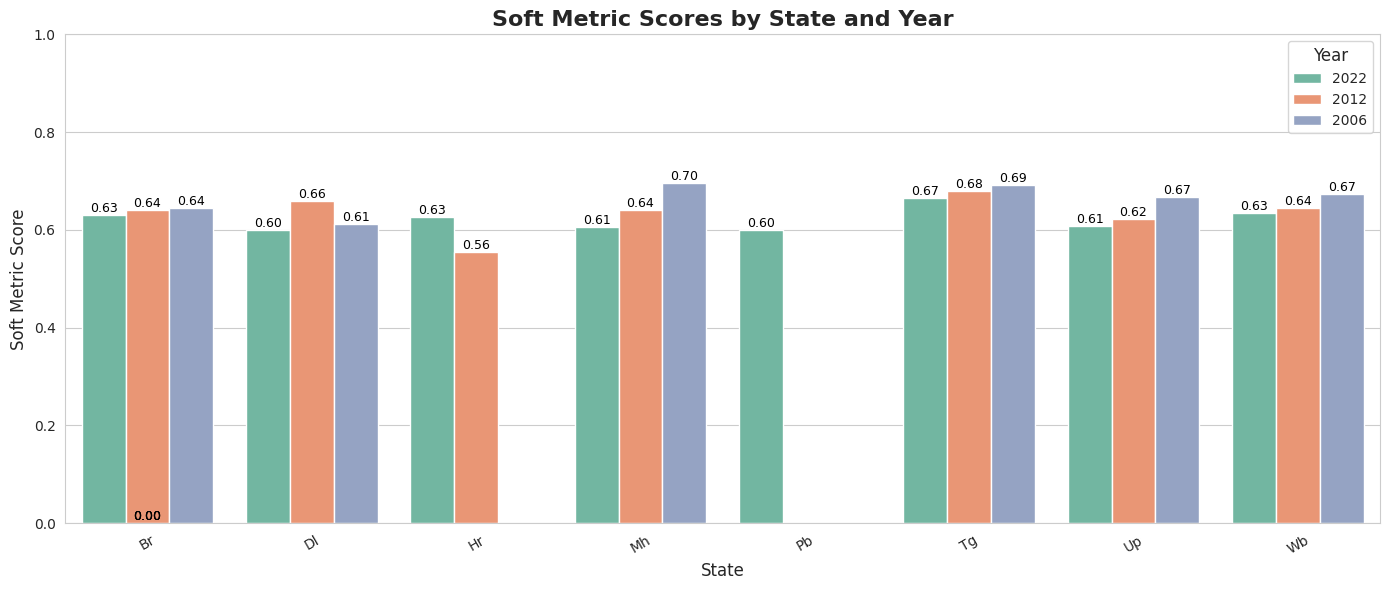

/tmp/ipykernel_527392/2739336116.py:37: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.barplot(data=final_table, x='State', y='hard_metric', hue='Year', palette=palette)


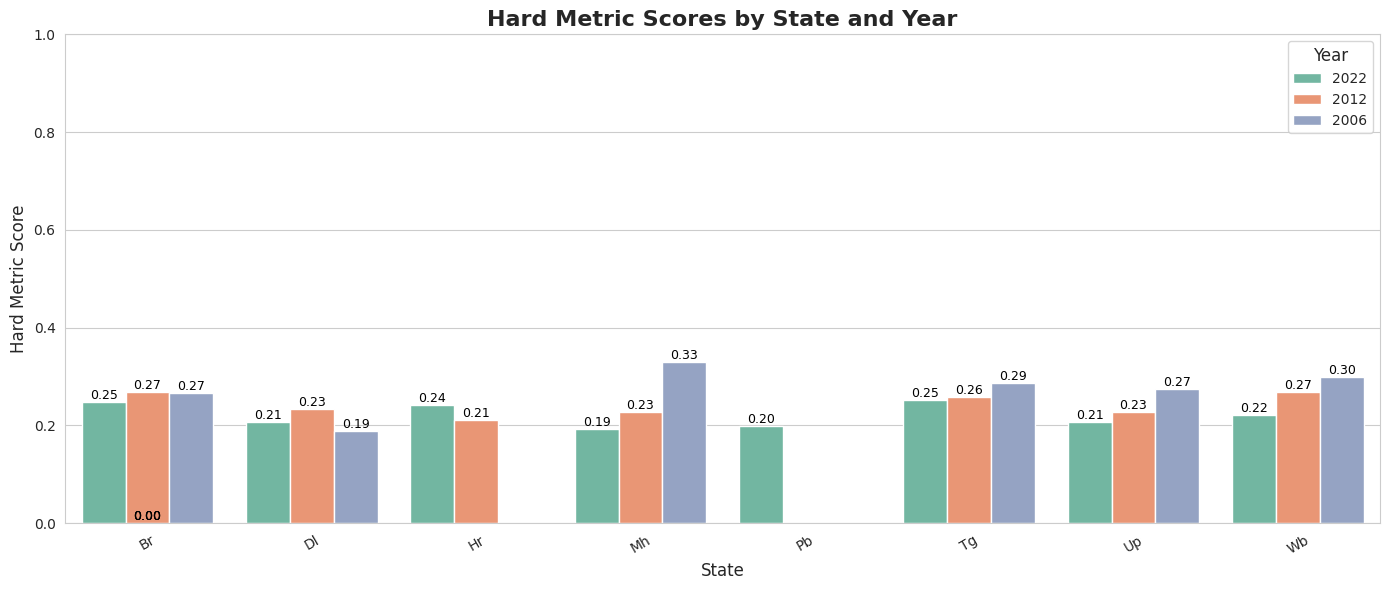

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style and palette
sns.set_style("whitegrid")
palette = sns.color_palette("Set2")

# Concatenate all years
final_table = pd.concat([df.assign(Year=year) for year, df in total_results.items()], ignore_index=True)

# Function to annotate bars
def annotate_bars(ax, fmt="{:.2f}"):
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):
            ax.annotate(fmt.format(height),
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=9, color='black')

# Plot Soft Metrics
plt.figure(figsize=(14,6))
ax = sns.barplot(data=final_table, x='State', y='soft_metric', hue='Year', palette=palette)
plt.title('Soft Metric Scores by State and Year', fontsize=16, weight='bold')
plt.ylabel('Soft Metric Score', fontsize=12)
plt.xlabel('State', fontsize=12)
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.legend(title='Year', fontsize=10, title_fontsize=12)
annotate_bars(ax)
plt.tight_layout()
plt.show()

# Plot Hard Metrics
plt.figure(figsize=(14,6))
ax = sns.barplot(data=final_table, x='State', y='hard_metric', hue='Year', palette=palette)
plt.title('Hard Metric Scores by State and Year', fontsize=16, weight='bold')
plt.ylabel('Hard Metric Score', fontsize=12)
plt.xlabel('State', fontsize=12)
plt.xticks(rotation=30)
plt.ylim(0, 1)
plt.legend(title='Year', fontsize=10, title_fontsize=12)
annotate_bars(ax)
plt.tight_layout()
plt.show()

### Countries
Russia, USA, Japan and India are considered for this analysis

In [8]:
import pandas as pd
import numpy as np
from collections import defaultdict

countries = ['japan', 'US', 'india', 'russia']

print("\n--- Year: 2022 ---")

all_results_countries = defaultdict(list)
for country in countries:
    results = analyze_survey_alignment(country=country, mode='country', year='2022', region_wise=False, verbose=False)
    combined = {
        'Country': country,
        'soft_metric': results.get('soft_metric'),
        'hard_metric': results.get('hard_metric')
    }
    all_results_countries['2022'].append(combined)
final_table = pd.DataFrame(all_results_countries['2022'], columns=['Country', 'soft_metric', 'hard_metric'])
print(final_table)

print("\n--- Year: 2012 ---")
for country in countries:
    results = analyze_survey_alignment(country=country, mode='country', year='2012', region_wise=False, verbose=False)
    combined = {
        'Country': country,
        'soft_metric': results.get('soft_metric'),
        'hard_metric': results.get('hard_metric')
    }
    all_results_countries['2012'].append(combined)
final_table = pd.DataFrame(all_results_countries['2012'], columns=['Country', 'soft_metric', 'hard_metric'])
print(final_table)

print("\n--- Year: 2006 ---")
for country in countries:
    results = analyze_survey_alignment(country=country, mode='country', year='2006', region_wise=False, verbose=False)
    combined = {
        'Country': country,
        'soft_metric': results.get('soft_metric'),
        'hard_metric': results.get('hard_metric')
    }
    all_results_countries['2006'].append(combined)

final_table = pd.DataFrame(all_results_countries['2006'], columns=['Country', 'soft_metric', 'hard_metric'])
print(final_table)


--- Year: 2022 ---
  Country  soft_metric  hard_metric
0   japan     0.711140     0.339021
1      US     0.677902     0.299686
2   india     0.611792     0.211722
3  russia          NaN          NaN

--- Year: 2012 ---


/tmp/ipykernel_846958/1932499554.py:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wvs_df['urban_rural'] = [['urban', 'rural']] * len(wvs_df)


KeyError: 'urban_rural'

In [229]:
import pandas as pd
import numpy as np

countries = ['japan', 'US', 'india']

print("\n--- Year: 2022 ---")

all_results_countries = defaultdict(list)
for country in countries:
    results = analyze_survey_alignment(country=country, mode='country', year='2022', region_wise=False, verbose=False)
    combined = {
        'Country': country,
        'soft_metric': results.get('soft_metric'),
        'hard_metric': results.get('hard_metric')
    }
    all_results_countries['2022'].append(combined)
final_table = pd.DataFrame(all_results_countries['2022'], columns=['Country', 'soft_metric', 'hard_metric'])
print(final_table)

print("\n--- Year: 2012 ---")
for country in countries:
    results = analyze_survey_alignment(country=country, mode='country', year='2012', region_wise=False, verbose=False)
    combined = {
        'Country': country,
        'soft_metric': results.get('soft_metric'),
        'hard_metric': results.get('hard_metric')
    }
    all_results_countries['2012'].append(combined)
final_table = pd.DataFrame(all_results_countries['2012'], columns=['Country', 'soft_metric', 'hard_metric'])
print(final_table)

print("\n--- Year: 2006 ---")
for country in countries:
    results = analyze_survey_alignment(country=country, mode='country', year='2006', region_wise=False, verbose=False)
    combined = {
        'Country': country,
        'soft_metric': results.get('soft_metric'),
        'hard_metric': results.get('hard_metric')
    }
    all_results_countries['2006'].append(combined)

final_table = pd.DataFrame(all_results_countries['2006'], columns=['Country', 'soft_metric', 'hard_metric'])
print(final_table)


--- Year: 2022 ---
  Country  soft_metric  hard_metric
0   japan     0.711140     0.339021
1      US     0.677902     0.299686
2   india     0.611792     0.211722

--- Year: 2012 ---


/tmp/ipykernel_527392/1932499554.py:161: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  wvs_df['urban_rural'] = [['urban', 'rural']] * len(wvs_df)


  Country  soft_metric  hard_metric
0   japan     0.713801     0.270217
1      US     0.681406     0.271939
2   india     0.647829     0.206035

--- Year: 2006 ---
  Country  soft_metric  hard_metric
0   japan     0.729624     0.272152
1      US     0.679993     0.249267
2   india     0.668792     0.218997


/tmp/ipykernel_527392/3812251087.py:24: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.barplot(


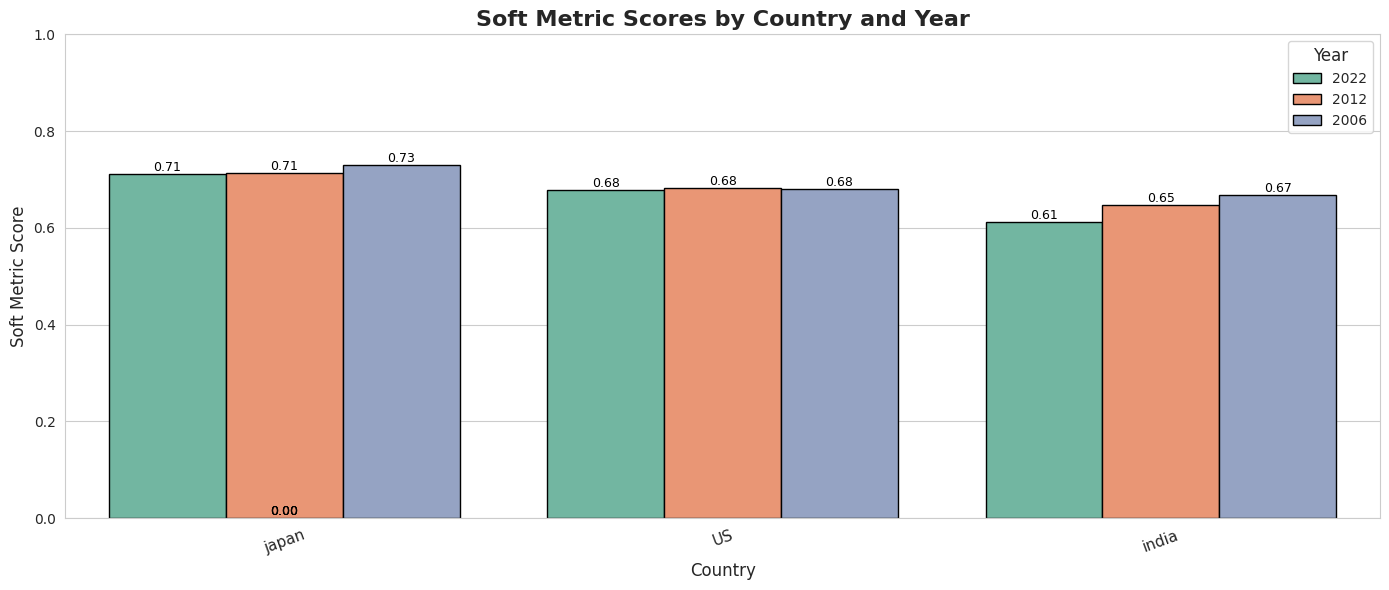

/tmp/ipykernel_527392/3812251087.py:39: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  ax = sns.barplot(


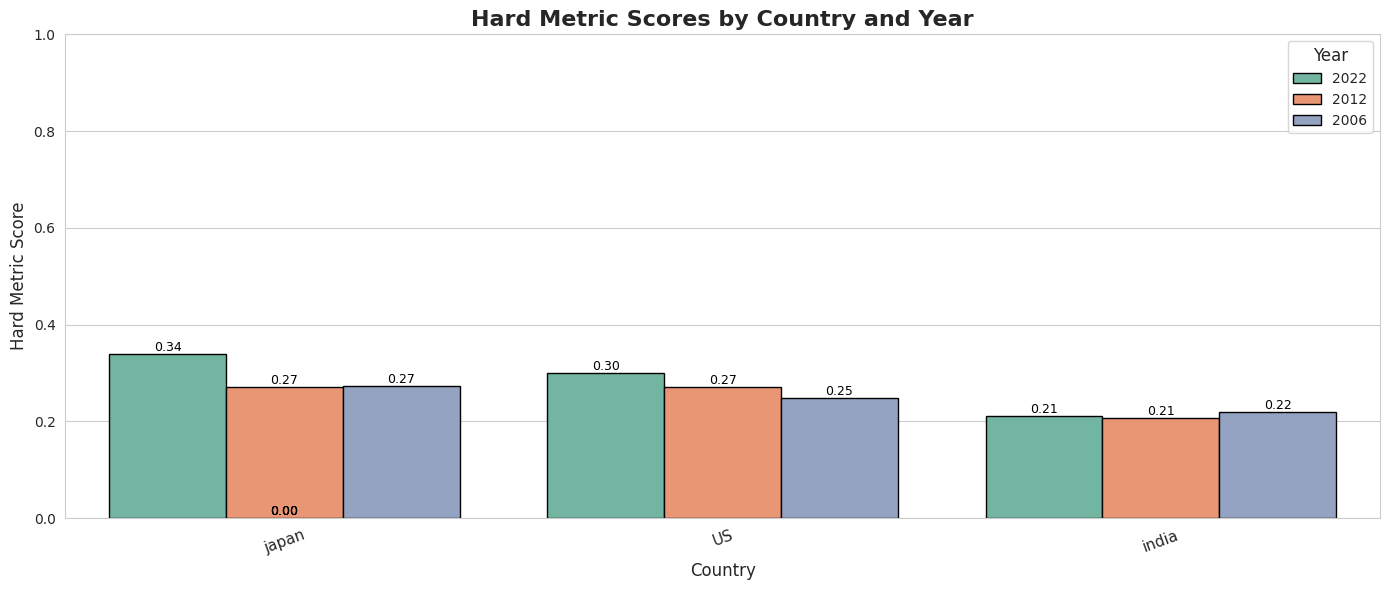

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

final_table = pd.concat(
    [pd.DataFrame(data).assign(Year=year) for year, data in all_results_countries.items()],
    ignore_index=True
)

def annotate_bars(ax, fmt="{:.2f}"):
    """Add value annotations above bars."""
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):
            ax.annotate(fmt.format(height),
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=9, color='black')

plt.figure(figsize=(14,6))
soft_palette = sns.color_palette("Set2")
ax = sns.barplot(
    data=final_table, x='Country', y='soft_metric', hue='Year', palette=soft_palette, edgecolor='black'
)
plt.title('Soft Metric Scores by Country and Year', fontsize=16, weight='bold')
plt.ylabel('Soft Metric Score', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.xticks(rotation=20, fontsize=11)
plt.ylim(0, 1)
plt.legend(title='Year', fontsize=10, title_fontsize=12)
annotate_bars(ax)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))
hard_palette = sns.color_palette("Set2")
ax = sns.barplot(
    data=final_table, x='Country', y='hard_metric', hue='Year', palette=hard_palette, edgecolor='black'
)
plt.title('Hard Metric Scores by Country and Year', fontsize=16, weight='bold')
plt.ylabel('Hard Metric Score', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.xticks(rotation=20, fontsize=11)
plt.ylim(0, 1)
plt.legend(title='Year', fontsize=10, title_fontsize=12)
annotate_bars(ax)
plt.tight_layout()
plt.show()


## 3. Theme Similarity

### Indian States
Indian States of West Bengal, Telangana/Andhra Pradesh, Maharashtra, Uttar Pradesh, Bihar are considered for this analysis

In [218]:
states = ['bengal', 'telangana', 'maharashtra', 'bihar', 'delhi', 'up']
for state in states:
    print(f"\nFor the state: {state}")
    results = compute_similarity_per_theme(state=state)
    for theme, score in results['per_theme'].items():
        if score is not np.nan and results['per_theme_counts'][theme] > 1:
            print(f"{theme}: {score:.3f}, No. of questions: {results['per_theme_counts'][theme]}")


For the state: bengal
SOCIAL VALUES, ATTITUDES & STEREOTYPES: 0.589, No. of questions: 24
SOCIAL CAPITAL, TRUST & ORGANIZATIONAL MEMBERSHIP: 0.596, No. of questions: 23
ECONOMIC VALUES: 0.840, No. of questions: 6
POSTMATERIALIST INDEX: 0.558, No. of questions: 6
SCIENCE & TECHNOLOGY: 0.579, No. of questions: 4
ETHICAL VALUES AND NORMS: 0.635, No. of questions: 11
POLITICAL CULTURE & POLITICAL REGIMES: 0.723, No. of questions: 15

For the state: telangana
SOCIAL VALUES, ATTITUDES & STEREOTYPES: 0.641, No. of questions: 24
SOCIAL CAPITAL, TRUST & ORGANIZATIONAL MEMBERSHIP: 0.716, No. of questions: 23
ECONOMIC VALUES: 0.635, No. of questions: 6
POSTMATERIALIST INDEX: 0.618, No. of questions: 6
SCIENCE & TECHNOLOGY: 0.663, No. of questions: 4
ETHICAL VALUES AND NORMS: 0.701, No. of questions: 11
POLITICAL CULTURE & POLITICAL REGIMES: 0.748, No. of questions: 15

For the state: maharashtra
SOCIAL VALUES, ATTITUDES & STEREOTYPES: 0.549, No. of questions: 24
SOCIAL CAPITAL, TRUST & ORGANIZAT

/tmp/ipykernel_527392/1447220694.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(states))


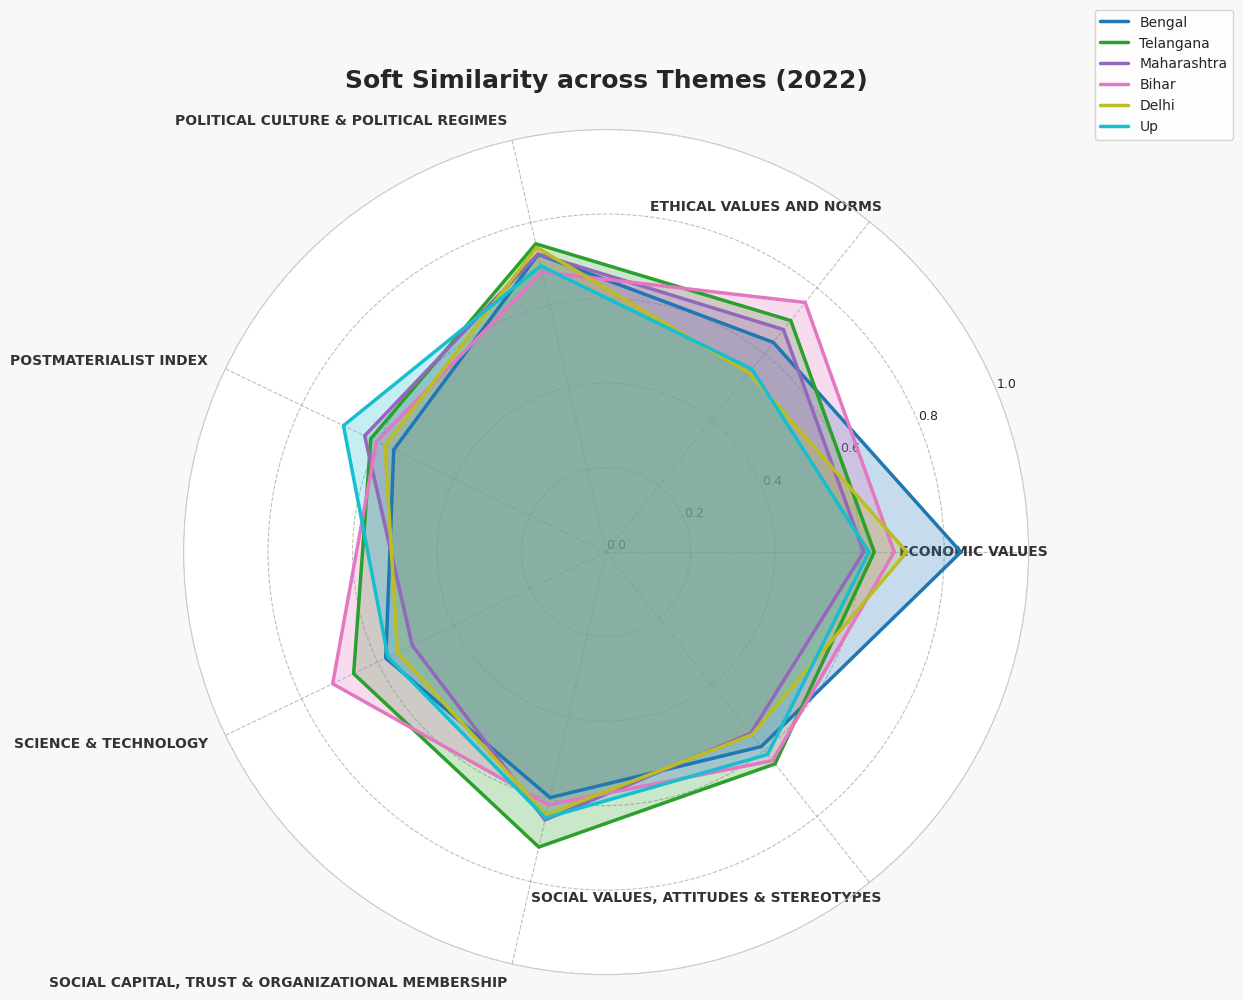

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

states = ['bengal', 'telangana', 'maharashtra', 'bihar', 'delhi', 'up']
all_theme_scores = {}

# Collect per-theme scores for all states
for state in states:
    results = compute_similarity_per_theme(state=state)
    theme_results = {theme: score for theme, score in results['per_theme'].items()
                     if score is not np.nan and results['per_theme_counts'][theme] > 1}
    all_theme_scores[state] = theme_results

# Get all unique themes
themes = sorted({theme for scores in all_theme_scores.values() for theme in scores.keys()})

# Prepare angles
num_vars = len(themes)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Initialize polar subplot
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))
fig.patch.set_facecolor('#f8f8f8') 

# Choose a colormap
colors = cm.get_cmap('tab10', len(states))

# Plot each state
for idx, (state, scores) in enumerate(all_theme_scores.items()):
    values = [scores.get(theme, 0) for theme in themes]
    values += values[:1]
    ax.plot(angles, values, linewidth=2.5, color=colors(idx), label=state.capitalize())
    ax.fill(angles, values, color=colors(idx), alpha=0.25)

# Set theme labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(themes, fontsize=10, fontweight='bold', color='#333333')

# Rotate labels for readability
for label, angle in zip(ax.get_xticklabels(), angles):
    label.set_rotation(np.degrees(angle))
    label.set_horizontalalignment('right')

# Set y-labels and range
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels([f"{x:.1f}" for x in np.linspace(0, 1, 6)], fontsize=9)
ax.set_ylim(0, 1)

# Grid style
ax.yaxis.grid(True, color='gray', linestyle='dashed', alpha=0.5)
ax.xaxis.grid(True, color='gray', linestyle='dashed', alpha=0.5)

# Title and legend
plt.title("Soft Similarity across Themes (2022)", size=18, pad=30, weight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.15), fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_527392/3533968115.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(states))


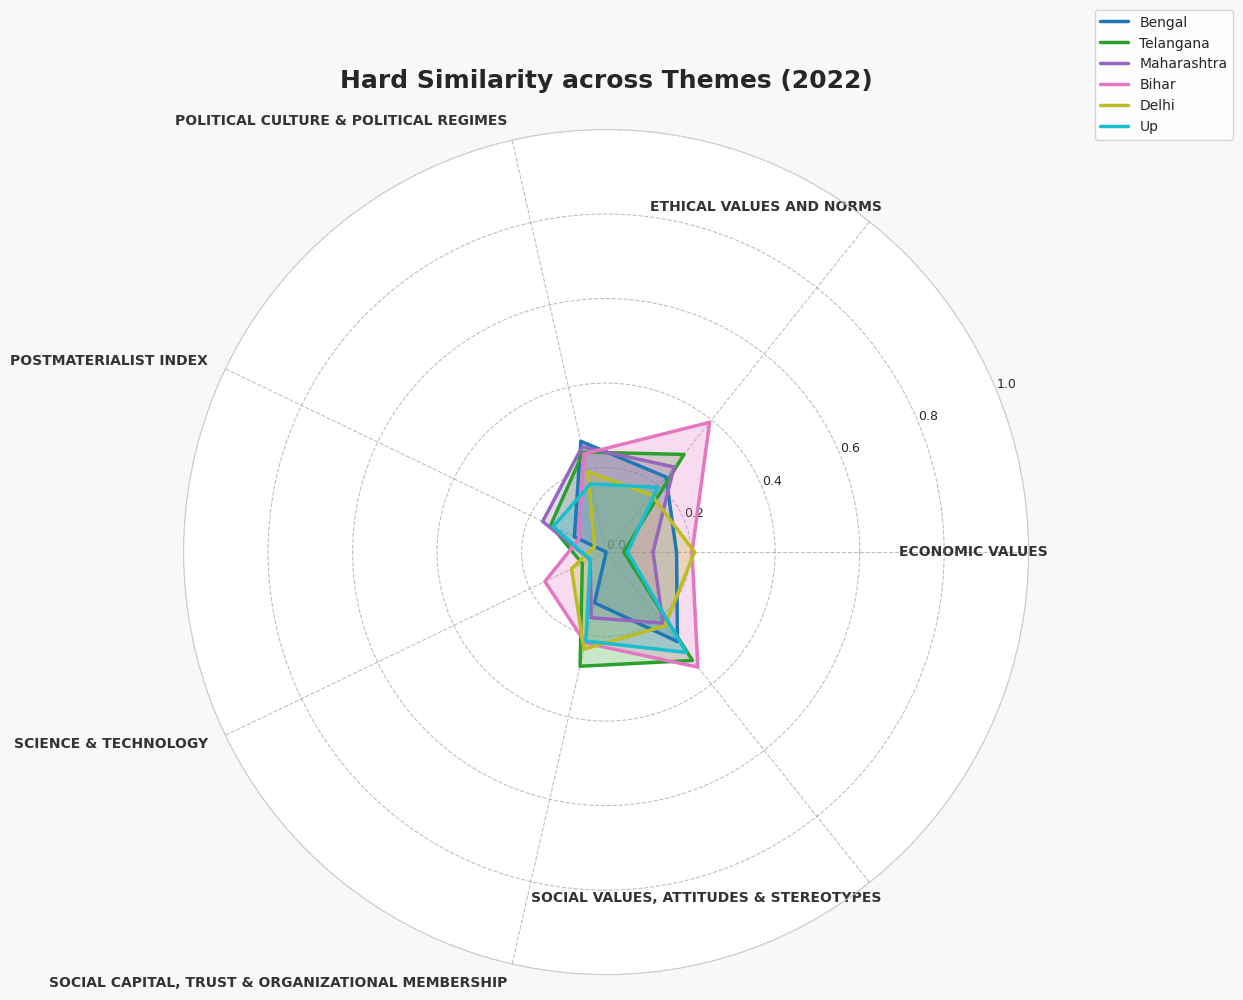

In [221]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

states = ['bengal', 'telangana', 'maharashtra', 'bihar', 'delhi', 'up']
all_theme_scores = {}

# Collect per-theme scores for all states
for state in states:
    results = compute_similarity_per_theme(state=state, metric_type='hard')
    theme_results = {theme: score for theme, score in results['per_theme'].items()
                     if score is not np.nan and results['per_theme_counts'][theme] > 1}
    all_theme_scores[state] = theme_results

# Get all unique themes
themes = sorted({theme for scores in all_theme_scores.values() for theme in scores.keys()})

# Prepare angles
num_vars = len(themes)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Initialize polar subplot
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))
fig.patch.set_facecolor('#f8f8f8') 

# Choose a colormap
colors = cm.get_cmap('tab10', len(states))

# Plot each state
for idx, (state, scores) in enumerate(all_theme_scores.items()):
    values = [scores.get(theme, 0) for theme in themes]
    values += values[:1]
    ax.plot(angles, values, linewidth=2.5, color=colors(idx), label=state.capitalize())
    ax.fill(angles, values, color=colors(idx), alpha=0.25)

# Set theme labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(themes, fontsize=10, fontweight='bold', color='#333333')

# Rotate labels for readability
for label, angle in zip(ax.get_xticklabels(), angles):
    label.set_rotation(np.degrees(angle))
    label.set_horizontalalignment('right')

# Set y-labels and range
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels([f"{x:.1f}" for x in np.linspace(0, 1, 6)], fontsize=9)
ax.set_ylim(0, 1)

# Grid style
ax.yaxis.grid(True, color='gray', linestyle='dashed', alpha=0.5)
ax.xaxis.grid(True, color='gray', linestyle='dashed', alpha=0.5)

# Title and legend
plt.title("Hard Similarity across Themes (2022)", size=18, pad=30, weight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.15), fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

### Countries

In [222]:
countries = ['india', 'japan', 'US']
for cnt in countries:
    print(f"\nFor the country: {cnt}")
    results = compute_similarity_per_theme(country=cnt, mode='country')
    for theme, score in results['per_theme'].items():
        if score is not np.nan and results['per_theme_counts'][theme] > 1:
            print(f"{theme}: {score:.3f}, No. of questions: {results['per_theme_counts'][theme]}")


For the country: india
SOCIAL VALUES, ATTITUDES & STEREOTYPES: 0.602, No. of questions: 24
SOCIAL CAPITAL, TRUST & ORGANIZATIONAL MEMBERSHIP: 0.640, No. of questions: 23
ECONOMIC VALUES: 0.667, No. of questions: 6
POSTMATERIALIST INDEX: 0.604, No. of questions: 6
SCIENCE & TECHNOLOGY: 0.601, No. of questions: 4
ETHICAL VALUES AND NORMS: 0.642, No. of questions: 11
POLITICAL CULTURE & POLITICAL REGIMES: 0.717, No. of questions: 15

For the country: japan
SOCIAL VALUES, ATTITUDES & STEREOTYPES: 0.679, No. of questions: 24
SOCIAL CAPITAL, TRUST & ORGANIZATIONAL MEMBERSHIP: 0.758, No. of questions: 22
ECONOMIC VALUES: 0.764, No. of questions: 6
POSTMATERIALIST INDEX: 0.631, No. of questions: 3
SCIENCE & TECHNOLOGY: 0.755, No. of questions: 4
ETHICAL VALUES AND NORMS: 0.665, No. of questions: 10
POLITICAL CULTURE & POLITICAL REGIMES: 0.760, No. of questions: 14

For the country: US
SOCIAL VALUES, ATTITUDES & STEREOTYPES: 0.701, No. of questions: 24
SOCIAL CAPITAL, TRUST & ORGANIZATIONAL ME

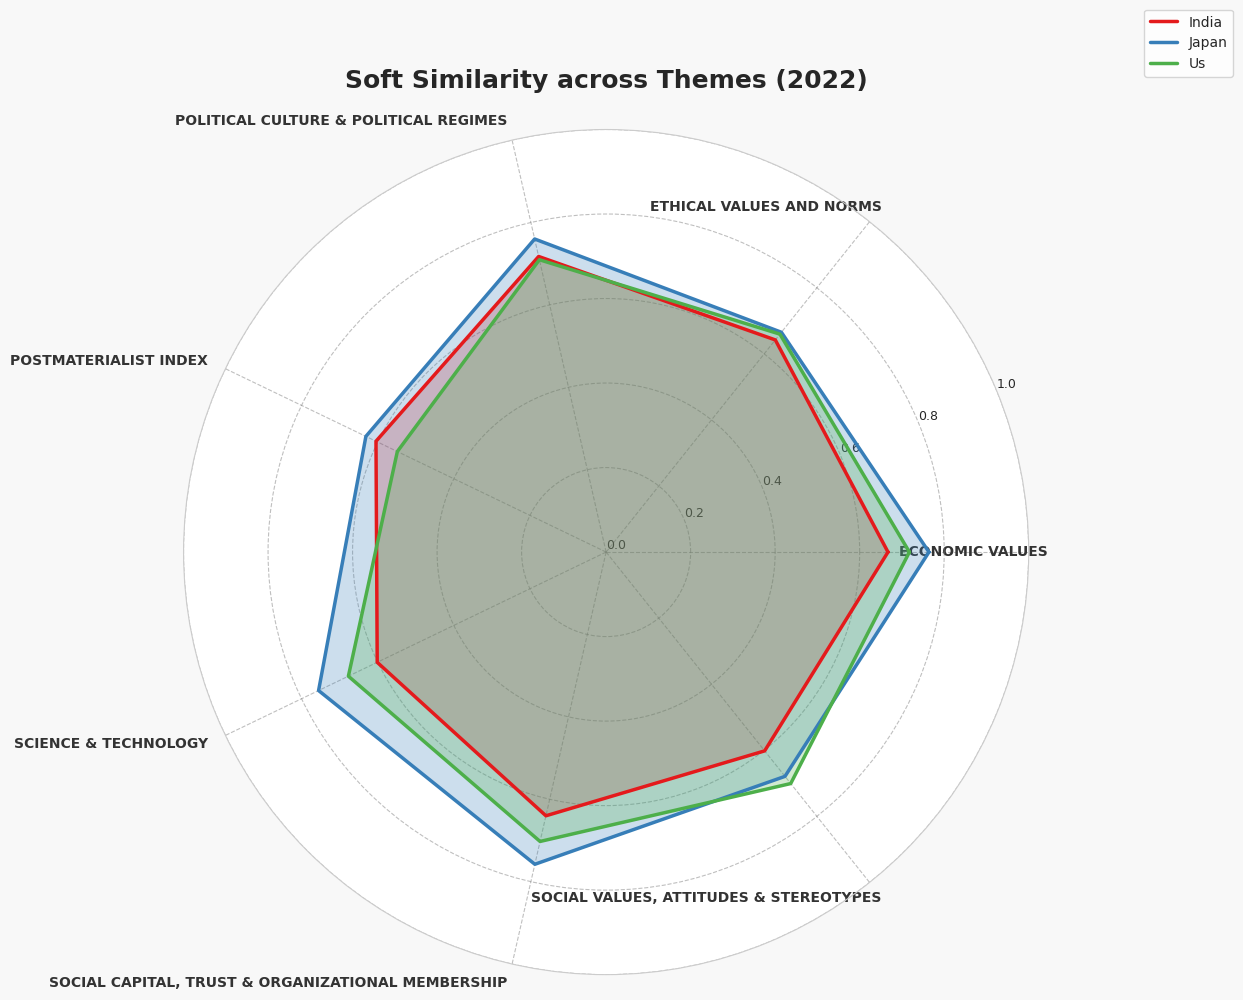

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

countries = ['india', 'japan', 'US']
all_theme_scores = {}

# Collect per-theme scores for all countries
for country in countries:
    results = compute_similarity_per_theme(country=country, mode='country')
    theme_results = {theme: score for theme, score in results['per_theme'].items() 
                     if score is not np.nan and results['per_theme_counts'][theme] > 1}
    all_theme_scores[country] = theme_results

# Keep only themes that are valid (non-NaN) in ALL countries
common_themes = sorted(
    set.intersection(*(set(scores.keys()) for scores in all_theme_scores.values()))
)

# Prepare angles for radar chart
num_vars = len(common_themes)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Initialize polar subplot
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))
fig.patch.set_facecolor('#f8f8f8')  # light background

# Use a high-contrast color palette (Set1)
palette = sns.color_palette("Set1", n_colors=len(countries))

# Plot each country
for idx, (country, scores) in enumerate(all_theme_scores.items()):
    values = [scores.get(theme, 0) for theme in common_themes]
    values += values[:1]
    color = palette[idx]
    ax.plot(angles, values, linewidth=2.5, color=color, label=country.capitalize())
    ax.fill(angles, values, color=color, alpha=0.25)

# Set theme labels around the circle
ax.set_xticks(angles[:-1])
ax.set_xticklabels(common_themes, fontsize=10, fontweight='bold', color='#333333')

# Rotate labels slightly for readability
for label, angle in zip(ax.get_xticklabels(), angles):
    label.set_rotation(np.degrees(angle))
    label.set_horizontalalignment('right')

# Set y-labels and range
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels([f"{x:.1f}" for x in np.linspace(0, 1, 6)], fontsize=9)
ax.set_ylim(0, 1)

# Grid style
ax.yaxis.grid(True, color='gray', linestyle='dashed', alpha=0.5)
ax.xaxis.grid(True, color='gray', linestyle='dashed', alpha=0.5)

# Title and legend
plt.title("Soft Similarity across Themes (2022)", size=18, pad=30, weight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.15), fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

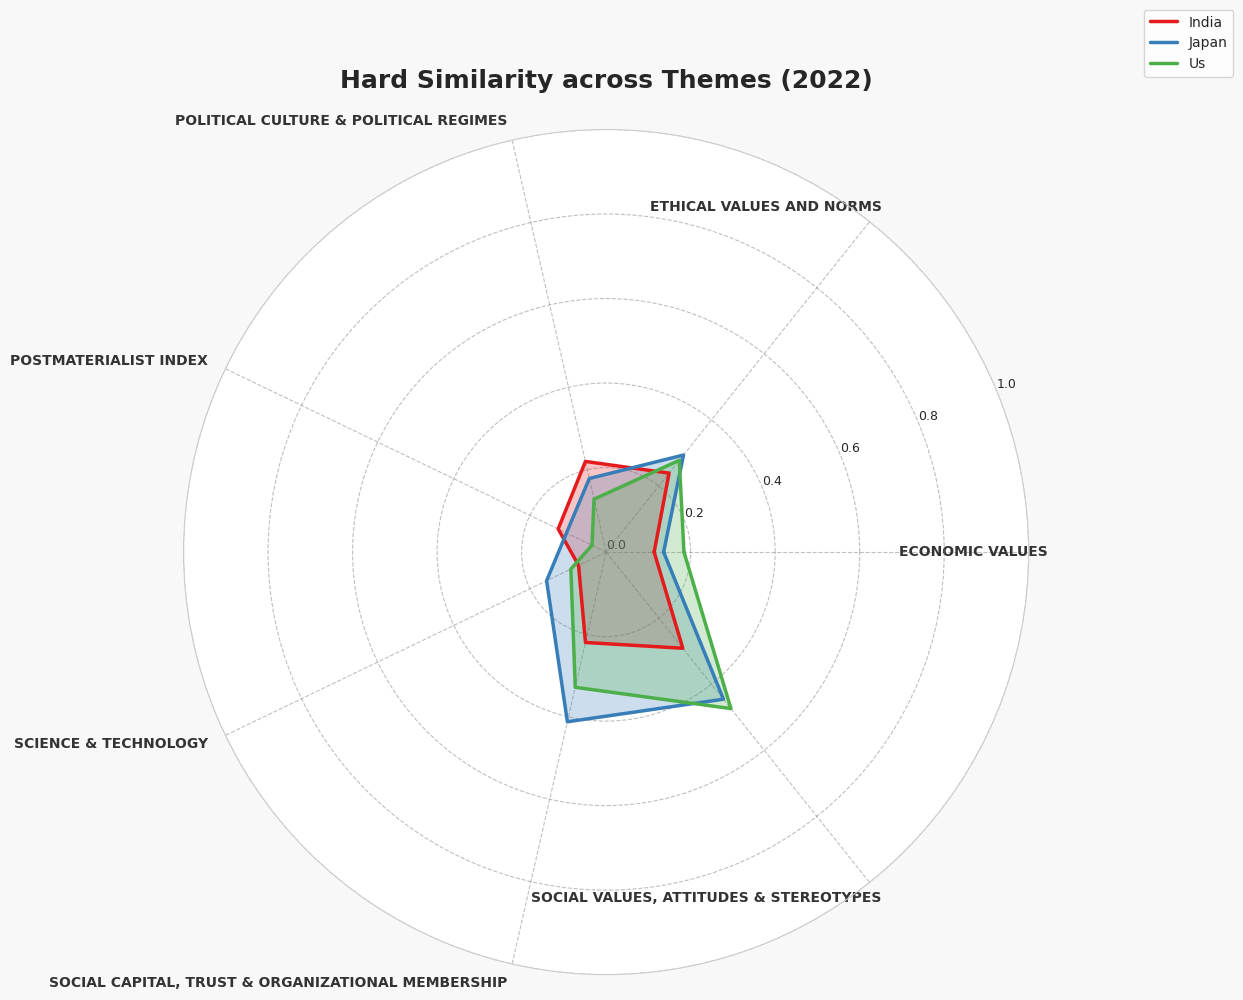

In [225]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

countries = ['india', 'japan', 'US']
all_theme_scores = {}

# Collect per-theme scores for all countries
for country in countries:
    results = compute_similarity_per_theme(country=country, mode='country', metric_type='hard')
    theme_results = {theme: score for theme, score in results['per_theme'].items() 
                     if score is not np.nan and results['per_theme_counts'][theme] > 1}
    all_theme_scores[country] = theme_results

# Keep only themes that are valid (non-NaN) in ALL countries
common_themes = sorted(
    set.intersection(*(set(scores.keys()) for scores in all_theme_scores.values()))
)

# Prepare angles for radar chart
num_vars = len(common_themes)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Initialize polar subplot
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))
fig.patch.set_facecolor('#f8f8f8')  # light background

# Use a high-contrast color palette (Set1)
palette = sns.color_palette("Set1", n_colors=len(countries))

# Plot each country
for idx, (country, scores) in enumerate(all_theme_scores.items()):
    values = [scores.get(theme, 0) for theme in common_themes]
    values += values[:1]
    color = palette[idx]
    ax.plot(angles, values, linewidth=2.5, color=color, label=country.capitalize())
    ax.fill(angles, values, color=color, alpha=0.25)

# Set theme labels around the circle
ax.set_xticks(angles[:-1])
ax.set_xticklabels(common_themes, fontsize=10, fontweight='bold', color='#333333')

# Rotate labels slightly for readability
for label, angle in zip(ax.get_xticklabels(), angles):
    label.set_rotation(np.degrees(angle))
    label.set_horizontalalignment('right')

# Set y-labels and range
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels([f"{x:.1f}" for x in np.linspace(0, 1, 6)], fontsize=9)
ax.set_ylim(0, 1)

# Grid style
ax.yaxis.grid(True, color='gray', linestyle='dashed', alpha=0.5)
ax.xaxis.grid(True, color='gray', linestyle='dashed', alpha=0.5)

# Title and legend
plt.title("Hard Similarity across Themes (2022)", size=18, pad=30, weight='bold')
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.15), fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

## 3. Language Analysis

In [ ]:
import pandas as pd
import numpy as np

states = {'bengal':'bn'}

all_results = []

for state, language in states.items():
    results_soft = analyze_survey_alignment(state=state, language=language, region_wise=True)
    results_hard = analyze_survey_alignment(state=state, language=language, metric_type='hard', region_wise=True)

    # Convert dicts to DataFrames
    df_soft = pd.DataFrame.from_dict(results_soft, orient='index')
    df_soft.index.name = 'Region'
    df_soft.reset_index(inplace=True)

    df_hard = pd.DataFrame.from_dict(results_hard, orient='index')
    df_hard.index.name = 'Region'
    df_hard.reset_index(inplace=True)

    # Merge soft and hard metrics side by side
    df_combined = pd.merge(df_soft, df_hard, on='Region', how='outer', suffixes=('_soft', '_hard'))
    df_combined['State'] = state
    all_results.append(df_combined)

# Concatenate all states
final_table = pd.concat(all_results, ignore_index=True)

# Add missing metric columns if needed
for col in ['soft_metric_unified', 'hard_metric']:
    if col not in final_table.columns:
        final_table[col] = np.nan

# Reorder columns safely
final_table = final_table[['State', 'Region', 'soft_metric_unified', 'hard_metric']]

# Display
print(final_table)

Index(['year', 'country', 'region', 'urban_rural', 'gender', 'age', 'language',
       'marital_status', 'education_level', 'social_class',
       ...
       'G46_3', 'G46_4', 'G46_5', 'G47_1', 'G47_2', 'G47_3', 'G47_4', 'G47_5',
       'G1_2', 'G1_3'],
      dtype='object', length=456)
Index(['language', 'marital_status', 'gender', 'urban_rural', 'region', 'age',
       'education_level', 'social_class', 'Q106', 'Q107', 'Q108', 'Q110',
       'Q150', 'Q151', 'Q158', 'Q159', 'Q160', 'Q161', 'Q162', 'Q176', 'Q177',
       'Q178', 'Q179', 'Q180', 'Q181', 'Q184', 'Q185', 'Q187', 'Q188', 'Q189',
       'Q190', 'Q191', 'Q192', 'Q194', 'Q195', 'Q224', 'Q225', 'Q227', 'Q228',
       'Q229', 'Q230', 'Q231', 'Q232', 'Q233', 'Q234', 'Q235', 'Q236', 'Q238',
       'Q239', 'Q241', 'Q242', 'Q244', 'Q247', 'Q248', 'Q33', 'Q34', 'Q35',
       'Q37', 'Q38', 'Q39', 'Q40', 'Q41', 'Q42', 'Q43', 'Q44', 'Q45', 'Q64',
       'Q66', 'Q67', 'Q68', 'Q72', 'Q73', 'Q74', 'Q75', 'Q77', 'Q78', 'Q79',
       'Q80',